In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aeons.utils import *
from aeons.regress import *
from aeons.endpoint import *
from aeons.plotting import *
figsettings()

In [37]:
def get_beta_DKL(points, ndead):
    logX = points.logX().iloc[ndead]
    if logX < -points.D_KL():
        return 1
    def func(beta):
        return logX + points.set_beta(beta).D_KL()
    from scipy import optimize
    res = optimize.root_scalar(func, bracket=[0, 1])
    return res.root

def get_beta_finish(points, ndead, epsilon=1e-3):
    logX = points.logX()
    logL = points.logL
    # Check if already terminated
    logw = logL + logX
    w = np.exp(logw - logw.max())
    Zdead = np.sum(w[:ndead])
    Zlive = np.sum(w[ndead:])
    if Zlive/Zdead < epsilon:
        return 1
    # Otherwise, find beta
    def func(beta):
        logw = beta * logL + logX
        w = np.exp(logw - logw.max())
        Zdead = np.sum(w[:ndead])
        Zlive = np.sum(w[ndead:])
        return Zlive/Zdead - epsilon
    from scipy import optimize
    try:
        res = optimize.root_scalar(func, bracket=[0, 1])
        return res.root
    except:
        return 0

def get_dGs(get_beta, samples, iterations, Nset=10, **kwargs):
    """Get the dG of the samples at each iteration for a given function get_beta."""
    iterations = iterations.astype(int)
    d_Gs = np.zeros(len(iterations))
    d_Gs_std = np.zeros(len(iterations))
    for i, iteration in enumerate(iterations):
        points = points_at_iteration(samples, iteration)
        beta = get_beta(points, iteration, **kwargs)
        points = points.set_beta(beta)
        d_Gs_i = points.d_G(Nset)
        d_Gs[i] = d_Gs_i.mean()
        d_Gs_std[i] = d_Gs_i.std()
        # Print progress bar
        print('\r', f'Iteration {iteration} of {iterations[-1]}, {d_Gs[i]}', end='')
    return d_Gs, d_Gs_std

### Compare the choice of beta for the elongated Gaussian

In [4]:
name, samples = get_samples('toy', 'gauss_3_6')
model = EndModel(samples)
true_endpoint = model.true_endpoint()

In [13]:
iterations = make_iterations(true_endpoint, 25)
dGs_DKL, dGs_DKL_std = get_dGs(beta_DKL, samples, iterations)
dGs_finish, dGs_finish_std = get_dGs(beta_finish, samples, iterations)
logXs = samples.logX().iloc[iterations]

 Iteration 2183 of 12805, 5.2581331680219535e-36

/tmp/ipykernel_152339/3006637485.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  if Zlive/Zdead < epsilon:
/tmp/ipykernel_152339/3006637485.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  return Zlive/Zdead - epsilon


 Iteration 12805 of 12805, 1.9339657918708863366

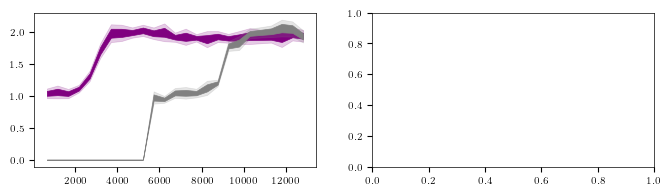

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
plot_std(iterations, dGs_DKL, dGs_DKL_std, label='DKL', ax=axs[0], color='purple')
plot_std(iterations, dGs_finish, dGs_finish_std, label='Finish', ax=axs[0], color='gray')
# plt.axvline(3.45, lw=1)

In [32]:
np.log(10**(-1.5))

-3.4538776394910684

2.0234306019975685

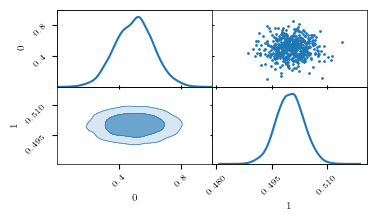

In [42]:
ndead = 4000
points = points_at_iteration(samples, ndead).recompute()
beta_DKL = get_beta_DKL(points, ndead)
points = points.set_beta(beta_DKL)
points.plot_2d([0, 1])
points.d_G()

### Run a comparison

In [16]:
name, samples = get_samples('lcdm', 'lensing')
model = EndModel(samples)
true_endpoint = model.true_endpoint()

In [17]:
iterations = make_iterations(true_endpoint, 25)
dG_DKL, dG_DKL_std = get_dGs(beta_DKL, samples, iterations)
dG_fin, dG_fin_std = get_dGs(beta_finish, samples, iterations)

 Iteration 18310 of 18310, 1.7801243515811376

/tmp/ipykernel_23869/3402999207.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  return Zlive/Zdead - epsilon


 Iteration 951 of 18310, 1.1373275186190253e-36

/tmp/ipykernel_23869/3402999207.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  return Zlive/Zdead - epsilon


 Iteration 1674 of 18310, 2.926613591562865e-37

/tmp/ipykernel_23869/3402999207.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  return Zlive/Zdead - epsilon


 Iteration 2398 of 18310, 1.4713240345960297e-36

/tmp/ipykernel_23869/3402999207.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  return Zlive/Zdead - epsilon


 Iteration 3121 of 18310, 6.921549509931629e-37

/tmp/ipykernel_23869/3402999207.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  return Zlive/Zdead - epsilon


 Iteration 3844 of 18310, 6.593513117655271e-37

/tmp/ipykernel_23869/3402999207.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  return Zlive/Zdead - epsilon


 Iteration 18310 of 18310, 8.608716807035181e-387

In [18]:
ndead = 12000
logL, X_mean, nk, logZdead = model.data(ndead)
points = points_at_iteration(samples, ndead)
beta_finish(points, ndead)

0.0006193675720708926

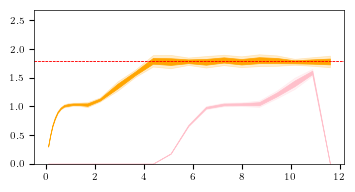

In [20]:
logXs = samples.logX().iloc[iterations]
fig, ax = plt.subplots()
plot_std(-logXs, dG_DKL, dG_DKL_std, samples.d_G(), (0, 1.5), ax=ax, color='orange')
plot_std(-logXs, dG_fin, dG_fin_std, samples.d_G(), (0, 1.5), ax=ax, color='pink')

In [ ]:
write_to_txt(f'{name}/dG_fin.txt', [iterations, dG_fin, dG_fin_std])
write_to_txt(f'{name}/dG_DKL.txt', [iterations, dG_DKL, dG_DKL_std])

### Results for Gauss and Cauchy

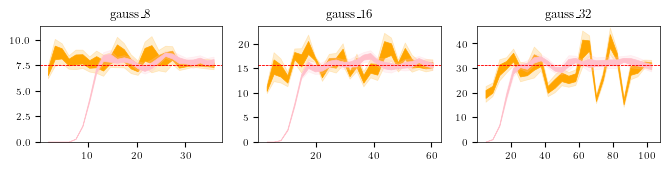

In [67]:
gauss_chains = ['gauss_8', 'gauss_16', 'gauss_32']
ylims = [(0, 1.5), (0, 1.5), (0, 1.5)]
fig, axs = plt.subplots(1, 3, figsize=(8, 1.5))
for i, chain in enumerate(gauss_chains):
    ax = axs[i]
    name, samples = get_samples('toy', f'{chain}')
    model = EndModel(samples)
    true_endpoint = model.true_endpoint()
    iterations, dG_fin, dG_fin_std = read_from_txt(f'{name}/dG_fin.txt')
    iterations, dG_DKL, dG_DKL_std = read_from_txt(f'{name}/dG_DKL.txt')
    logXs = samples.logX().iloc[iterations]
    plot_std(-logXs, dG_DKL, dG_DKL_std, dG_DKL[-1], ylims[i], ax=ax, color='orange')
    plot_std(-logXs, dG_fin, dG_fin_std, dG_DKL[-1], ylims[i], ax=ax, color='pink')
    ax.set_title(f'{chain}')

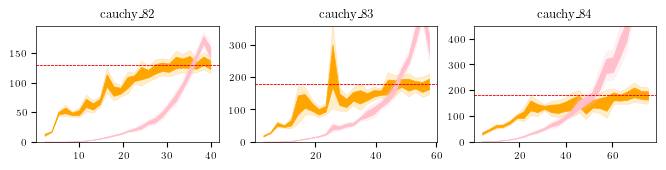

In [ ]:
cauchy_chains = ['cauchy_82', 'cauchy_83', 'cauchy_84']
ylims = [(0, 1.5), (0, 2), (0, 2.5)]
fig, axs = plt.subplots(1, 3, figsize=(8, 1.5))
for i, chain in enumerate(cauchy_chains):
    ax = axs[i]
    name, samples = get_samples('toy', f'{chain}')
    model = EndModel(samples)
    true_endpoint = model.true_endpoint()
    iterations, dG_fin, dG_fin_std = read_from_txt(f'{name}/dG_fin.txt')
    iterations, dG_DKL, dG_DKL_std = read_from_txt(f'{name}/dG_DKL.txt')
    logXs = samples.logX().iloc[iterations]
    plot_std(-logXs, dG_DKL, dG_DKL_std, dG_DKL[-1], ylims[i], ax=ax, color='orange')
    plot_std(-logXs, dG_fin, dG_fin_std, dG_DKL[-1], ylims[i], ax=ax, color='pink')
    ax.set_title(f'{chain}')

## Making $\log X^*$ the posterior mean value

In [29]:
def beta_mean(points, ndead):
    logXstar = points.logX().iloc[ndead]
    if logXstar < points.logX().mean():
        return 1
    def func(beta):
        return logXstar - points.set_beta(beta).logX().mean()
    from scipy import optimize
    res = optimize.root_scalar(func, bracket=[0, 1])
    return res.root

In [57]:
name, samples = get_samples('toy', 'cauchy_84')
model = EndModel(samples)
true_endpoint = model.true_endpoint()

In [63]:
ndead = 2000
points = points_at_iteration(samples, ndead)
beta_mean(points, ndead), beta_DKL(points, ndead), beta_finish(points, ndead)

(1, 0.7252266409501648, 0)

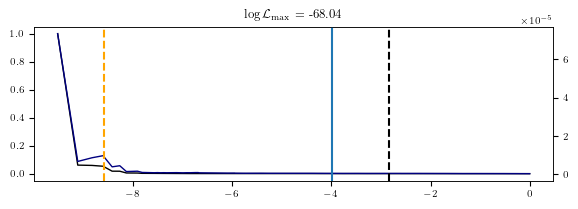

In [73]:
plot_lx(points)
plt.axvline(points.logX().mean(), color='k', linestyle='--')
plt.axvline(points.logX().iloc[ndead])
plt.axvline(-points.D_KL(), color='orange', linestyle='--')

In [53]:
iterations = make_iterations(true_endpoint, 50)
dG_mean, dG_mean_std = get_dGs(beta_mean, samples, iterations)
dG_DKL, dG_DKL_std = get_dGs(beta_DKL, samples, iterations)

 Iteration 38489 of 38489, 190.18278114790917

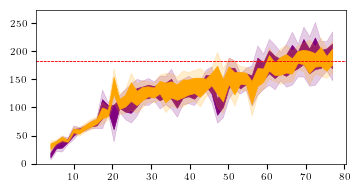

In [54]:
logXs = samples.logX().iloc[iterations]
fig, ax = plt.subplots()
plot_std(-logXs, dG_mean, dG_mean_std, samples.d_G(), (0, 1.5), ax=ax, color='purple')
plot_std(-logXs, dG_DKL, dG_DKL_std, samples.d_G(), (0, 1.5), ax=ax, color='orange')